# Hospital Acquired Infections in NY - 2008 to 2018 <a id='Top'></a>

## Executive Summary

- About 180 hospital facilities in NY reported annually on the number of hospital acquired infections observed within their facility between 2008 and 2018. The majority of these facilities are within the New York City metropolitan area.

- Clostridium difficile infections (CDI) account for almost 70% of observed infections. Despite having a much smaller number of total infections, surgical site infections (SSI) have a relatively high incidence per 100 procedures.

- There is a large variance in the incidence of SSI for Colon procedures across NY facilities. There may be opportunities here to study facilities with low SSI Colon incidences and develop standardized processes to limit variability. Facilities with high SSI Colon incidences can be prioritized for implementation of these processes.

[Skip to Analysis](#Analysis)

##### Data: https://healthdata.gov/dataset/hospital-acquired-infections-beginning-2008  
*The data used in this analysis was provided by the state of New York.*

# Table of Contents

- [Preparation](#Preparation)  
- [Get Data](#GetData)  
- [Add Features](#AddFeatures)  
- [Analysis](#Analysis)  
- [Conclusion](#Conclusion)  

<a id='Preparation'></a>
## Preparation

Import Python libraries to aid in analysis

In [3]:
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Import for reverse geocoding API calls
import requests
import urllib

# Import us to get additional county-level info
#import us

# Import time to avoid issues with API pull
import time

# Import mapping libraries
import os
import shapefile
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Point

import matplotlib.cm
from matplotlib.colors import Normalize

In [4]:
# Set Seaborn visualization styles
sns.set_style('darkgrid')

rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 10.0, 
    'axes.titlesize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.plotting_context()

{'font.size': 12.0,
 'axes.labelsize': 12.0,
 'axes.titlesize': 16.0,
 'xtick.labelsize': 12.0,
 'ytick.labelsize': 12.0,
 'legend.fontsize': 10.0,
 'axes.linewidth': 1.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 12.0}

<a id='GetData'></a>
## Get Data

Read in the csv dataset downloaded from https://healthdata.gov/dataset/hospital-acquired-infections-beginning-2008. 

Below is the summary description of this data as provided by healthdata.gov:

>*All acute care hospitals are required to report certain hospital-acquired infections (HAIs) to the New York State Department of Health (NYSDOH). This includes central line-associated blood stream infections; surgical site infections following colon, hip replacement/revision, coronary artery bypass graft, and hysterectomy; Clostridium difficile infections; and carbapenem-resistant Enterobacteriaceae infections.*

Source: [health.data.ny.gov](https://health.data.ny.gov)

In [5]:
hai_df = pd.read_csv('Hospital-Acquired_Infections__Beginning_2008.csv')

In [6]:
hai_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21661 entries, 0 to 21660
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Facility ID                       21661 non-null  int64  
 1   Hospital Name                     21661 non-null  object 
 2   Indicator Name                    21661 non-null  object 
 3   Year                              21661 non-null  int64  
 4   Infections Observed               20575 non-null  float64
 5   Infections Predicted              13657 non-null  float64
 6   Denominator                       18804 non-null  float64
 7   Indicator Value                   20575 non-null  float64
 8   Indicator Lower Confidence Limit  13657 non-null  float64
 9   Indicator Upper Confidence Limit  13657 non-null  float64
 10  Indicator Units                   19790 non-null  object 
 11  Comparison Results                21422 non-null  object 
 12  New 

In [7]:
set(hai_df['Indicator Name'])
# CDI = Clostridium difficile infections
# CLABSI = central line-associated blood stream infections
# SSI = surgical site infections following colon, hip replacement/revision, coronary artery bypass graft, and hysterectomy
# CRE = carbapenem-resistant Enterobacteriaceae infections

{'CDI Community Onset Not-My-Hospital',
 'CDI Hospital Onset',
 'CDI Possibly-My-Hospital Associated',
 'CLABSI Cardiothoracic ICU',
 'CLABSI Coronary ICU',
 'CLABSI Medical ICU',
 'CLABSI Medical Surgical ICU',
 'CLABSI Medical Surgical Ward',
 'CLABSI Medical Ward',
 'CLABSI Neonatal ICU Level 2/3',
 'CLABSI Neonatal ICU Level 3',
 'CLABSI Neonatal ICU Regional Perinatal Center',
 'CLABSI Neurosurgical ICU',
 'CLABSI Overall Standardized Infection Ratio',
 'CLABSI Pediatric ICU',
 'CLABSI Pediatric Ward',
 'CLABSI Step Down Unit',
 'CLABSI Surgical ICU',
 'CLABSI Surgical Ward',
 'CRE Admission Prevalence Rate- Bloodstream Infections',
 'CRE Admission Prevalence Rate- all body sites',
 'CRE Hospital Onset Infection Rate- Bloodstream Infections',
 'CRE Hospital Onset Infection Rate- all body sites',
 'SSI CABG chest site',
 'SSI CABG donor site',
 'SSI Colon',
 'SSI Hip',
 'SSI Hysterectomy'}

In [8]:
set(hai_df['Hospital Name'])

{'Adirondack Medical Center-Saranac Lake Site',
 'Albany Medical Center Hospital',
 'Albany Memorial Hospital',
 'Albert Lindley Lee Memorial Hospital',
 'Arnot Ogden Medical Center',
 'Auburn Community Hospital',
 'Aurelia Osborn Fox Memorial Hospital',
 'Bellevue Hospital Center',
 'Bertrand Chaffee Hospital',
 'Blythedale Childrens Hospital',
 'Bon Secours Community Hospital',
 'BronxCare Hospital Center',
 'Brookdale Hospital Medical Center',
 'Brooklyn Hospital Center - Downtown Campus',
 'Brooks-TLC Hospital System, Inc.',
 'Buffalo General Medical Center',
 'Calvary Hospital Inc',
 'Canton-Potsdam Hospital',
 'Carthage Area Hospital Inc',
 'Catskill Regional Medical Center',
 'Cayuga Medical Center at Ithaca',
 'Chenango Memorial Hospital Inc',
 'Claxton-Hepburn Medical Center',
 'Clifton Springs Hospital and Clinic',
 'Cobleskill Regional Hospital',
 'Cohen Childrens Medical Center',
 'Columbia Memorial Hospital',
 'Community Memorial Hospital Inc',
 'Coney Island Hospital',
 '

Copy into a new dataframe to add features and analyze

In [9]:
infections_df = hai_df.copy()

<a id='AddFeatures'></a>
## Add features

### Create indicator features

In [10]:
# Create indicator features
indicator_code = []
indicator_area = []


for val in infections_df['Indicator Name']:
    
    if val[0:6] == 'CLABSI':
        indicator_code.append('CLABSI')
        indicator_area.append(val[6:].strip())
        
    elif val[0:3] == 'CDI':
        indicator_code.append('CDI')
        indicator_area.append(val[3:].strip())
        
    elif val[0:3] == 'SSI':
        indicator_code.append('SSI')
        indicator_area.append(val[3:].strip())
        
    elif val[0:3] == 'CRE':
        indicator_code.append('CRE')
        indicator_area.append(val[3:].strip())
        
    else: 
        indicator_code == None
        indicator_area == None

infections_df['Indicator Code'] = indicator_code
infections_df['Indicator Area'] = indicator_area


indicator_dict = {
    'CDI':'Clostridium difficile infections',
    'CLABSI':'central line-associated blood stream infections',
    'SSI':'surgical site infections following colon, hip replacement/revision, coronary artery bypass graft, and hysterectomy',
    'CRE':'carbapenem-resistant Enterobacteriaceae infections'
}

code_long_name = []

for key in infections_df['Indicator Code']:
    code_long_name.append(indicator_dict[key])

infections_df['Indicator Code Long Name'] = code_long_name


### Remove totals rows for all NY state to a separate dataframe

There are 239 rows in the CSV file for "New York State - All Hospitals". These contain totals for the entire state. However, these rows do not contain any location information, so it does not make sense to include them in the main analysis dataframe any longer.

By separating them into their own dataframe, we can choose to analyze infections at the state level or at a more granular level.

In [11]:
all_ny_state = infections_df[infections_df['Facility ID'] == 0].reset_index(drop = True)

infections_df = infections_df[infections_df['Facility ID'] != 0].reset_index(drop = True)

Do these dataframes agree on the totals?

**How many total infections have been reported in the state of NY since 2008?  
What is the average number of infections reported per year?**

In [12]:
### This cell uses the totals rows from the raw data to answer these questions (ny_totals_df)

# Collect metrics
facility = all_ny_state['Hospital Name'].min()
year_count = all_ny_state['Year'].nunique()
total_infections = all_ny_state['Infections Observed'].astype(int).sum()
avg_infections_per_year = total_infections / year_count
avg_infections_per1000 = all_ny_state['Indicator Value'].mean()

# Display dataframe
ny_totals_df = pd.DataFrame({
    'Facility': facility,
    'Years in Dataset': year_count,
    'Total Infections Observed': total_infections,
    'Avg Infections per Year': avg_infections_per_year,
    'Avg Indicator Value': avg_infections_per1000
}, index = range(1))

format_dict = {
    'Total Infections Observed':'{0:,}', 
    'Avg Infections per Year': '{:,.3f}', 
    'Avg Indicator Value': '{:.3f}'}

ny_totals_df.style.format(format_dict).hide_index()

Facility,Years in Dataset,Total Infections Observed,Avg Infections per Year,Avg Indicator Value
New York State - All Hospitals,11,"210,816","19,165.091",1.744


In [13]:
### This cell aggregates the individual facility values from the raw data to answer these questions (infections_df)

facility = 'New York State - All Hospitals'
year_count = infections_df['Year'].nunique()
total_infections = infections_df['Infections Observed'].sum()
avg_infections_per_year = total_infections / year_count
avg_indicator_value = infections_df['Indicator Value'].mean()

totals_df = pd.DataFrame({
    'Facility': facility,
    'Years in Dataset': year_count,
    'Total Infections Observed': int(total_infections),
    'Avg Infections per Year': avg_infections_per_year,
    'Avg Indicator Value': avg_indicator_value
}, index = range(1))

format_dict = {
    'Total Infections Observed':'{0:,}', 
    'Avg Infections per Year': '{:,.3f}', 
    'Avg Indicator Value': '{:.3f}'}

totals_df.style.format(format_dict).hide_index()

Facility,Years in Dataset,Total Infections Observed,Avg Infections per Year,Avg Indicator Value
New York State - All Hospitals,11,"211,806","19,255.091",1.964


There is a slight difference in the data reported through the raw data's total rows compared to calculating the totals by aggregating individual facilities' data.

In [14]:
ny_totals_df['Source'] = 'Totals Rows'
totals_df['Source'] = 'Calculated'

compare_df = ny_totals_df.copy().append(totals_df.copy()).reset_index(drop = True)

compare_df.style.format(format_dict).hide_index()

Facility,Years in Dataset,Total Infections Observed,Avg Infections per Year,Avg Indicator Value,Source
New York State - All Hospitals,11,"210,816","19,165.091",1.744,Totals Rows
New York State - All Hospitals,11,"211,806","19,255.091",1.964,Calculated


Because the facility-level data is needed for the more detailed analyses, for consistency it is better to use the state-level metrics aggregated using this same facility-level data rather than the pre-aggregated totals rows that were included in the raw dataset. The Analysis section will not use the ny_totals_df data.

### Add location-based features

In [15]:
# With the totals rows removed, we can verify that all remaining rows contain values in the "New Georeferenced Column"
infections_df[infections_df['New Georeferenced Column'] == False]

,Facility ID,Hospital Name,Indicator Name,Year,Infections Observed,Infections Predicted,Denominator,Indicator Value,Indicator Lower Confidence Limit,Indicator Upper Confidence Limit,Indicator Units,Comparison Results,New Georeferenced Column,Indicator Code,Indicator Area,Indicator Code Long Name


In [16]:
# Split the georeferenced column into 3 new ones for Latitude, Longitude and a tuple containing both latitude and longitude
lat_list = []
lon_list = []
lats_lons = []

for val in infections_df['New Georeferenced Column']:
    
    geo = val.strip('()').split(', ')
    
    lat_list.append(float(geo[0]))
    lon_list.append(float(geo[1]))
    lats_lons.append((float(geo[0]), float(geo[1])))
    
infections_df['Latitude'] = lat_list
infections_df['Longitude'] = lon_list
infections_df['Lat_Lon'] = lats_lons

In [17]:
# Add nearest city based on lat and lon values
cities = []

for lat, lon in infections_df['Lat_Lon']:
    cities.append(citipy.nearest_city(lat, lon).city_name.title())
    
infections_df['City'] = cities

#### Collect county-level geographic information from Census Block API

Source: https://geo.fcc.gov/api/census/

In [18]:
# To avoid making unnecessary API calls, create a set including only the unique Lat_Lon combinations
lat_lon_set = set(infections_df['Lat_Lon'])

#This greatly reduces the number of API calls required.
print('Total records in dataset: ', len(infections_df['Lat_Lon']))
print('Total API calls to make: ', len(lat_lon_set))

Total records in dataset:  21422
Total API calls to make:  197


In [19]:
# Sample API result
lat, lon = infections_df['Lat_Lon'][0]
params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json', 'showall':'true'})
url = 'https://geo.fcc.gov/api/census/block/find?' + params
response = requests.get(url)
data = response.json()
pprint(data)

{'Block': {'FIPS': '360110414002008',
           'bbox': [-76.566912, 42.940697, -76.562665, 42.942499],
           'intersection': [{'FIPF': '360110414002008'},
                            {'FIPF': '360110414003003'}]},
 'County': {'FIPS': '36011', 'name': 'Cayuga'},
 'State': {'FIPS': '36', 'code': 'NY', 'name': 'New York'},
 'executionTime': '0',
 'messages': ['FCC0001: The coordinate lies on the boundary of mulitple '
              'blocks.'],
 'status': 'OK'}


In [32]:
# Build a new dataframe with the API call results
geo_dict = {
    'Lat': [],
    'Lon': [],
    'Lat_Lon': [],
    'County FIPS': [],
    'County Name': [],
    'Block FIPS': [],
    'Block bbox': [],
    'Block intersection FIPF1': [],
    'Block intersection FIPF2': []
}

for lat,lon in lat_lon_set:

    #Encode parameters 
    params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json', 'showall':'true'})

    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()
    
    #Save geo data
    geo_dict['Lat'].append(lat)
    geo_dict['Lon'].append(lon)
    geo_dict['Lat_Lon'].append((lat,lon))
    geo_dict['County FIPS'].append(data['County']['FIPS'])
    geo_dict['County Name'].append(data['County']['name'])
    geo_dict['Block FIPS'].append(data['Block']['FIPS'])
    geo_dict['Block bbox'].append(data['Block']['bbox'])
    
    try: #not all records have intersection data
        geo_dict['Block intersection FIPF1'].append(data['Block']['intersection'][0]['FIPF'])
        geo_dict['Block intersection FIPF2'].append(data['Block']['intersection'][1]['FIPF'])
    except:
        geo_dict['Block intersection FIPF1'].append(np.nan)
        geo_dict['Block intersection FIPF2'].append(np.nan)
    
    time.sleep(1) # make no more than 1 API call per second 
    
geo_df = pd.DataFrame.from_dict(geo_dict)
print('Done')

Done


In [33]:
geo_df.head()

,Lat,Lon,Lat_Lon,County FIPS,County Name,Block FIPS,Block bbox,Block intersection FIPF1,Block intersection FIPF2
0,40.764080,-73.954926,"(40.76408, -73.954926)",36061,New York,360610116001002,"[-73.955616, 40.763428, -73.952578, 40.765545]",360610116001002,360610116001006
1,41.934223,-73.912331,"(41.934223, -73.912331)",36027,Dutchess,360271600052000,"[-73.915986, 41.93322, -73.908026, 41.939901]",360271600052000,360271600053009
2,41.196774,-73.724510,"(41.196774, -73.72451)",36119,Westchester,361190130002000,"[-73.72763, 41.194737, -73.724435, 41.198614]",361190130002000,361190130003019
3,41.291512,-73.893341,"(41.291512, -73.893341)",36119,Westchester,361190147014015,"[-73.89607, 41.29128, -73.889346, 41.294308]",361190147014015,361190146071007
4,41.717392,-73.929420,"(41.717392, -73.92942)",36027,Dutchess,360271401011014,"[-73.930873, 41.717216, -73.925437, 41.720231]",360271401011014,360271401011020


In [34]:
# Write the geo_df data to a CSV file
geo_df.to_csv('NY_geo.csv', index = False)

#### Merge county data into main dataframe

In [20]:
# read data back in from CSV if needed
geo_df = pd.read_csv('NY_geo.csv')
geo_df['Lat_Lon'] = geo_df[['Lat', 'Lon']].apply(tuple, axis=1)

In [21]:
# Merge in county data by (lat,Lon)
infections_df = pd.merge(infections_df, geo_df, how='left',
        left_on='Lat_Lon', right_on='Lat_Lon')

# Drop redundant columns
infections_df.drop('Lat', axis = 1, inplace = True)
infections_df.drop('Lon', axis = 1, inplace = True)

In [22]:
infections_df.columns

Index(['Facility ID', 'Hospital Name', 'Indicator Name', 'Year',
       'Infections Observed', 'Infections Predicted', 'Denominator',
       'Indicator Value', 'Indicator Lower Confidence Limit',
       'Indicator Upper Confidence Limit', 'Indicator Units',
       'Comparison Results', 'New Georeferenced Column', 'Indicator Code',
       'Indicator Area', 'Indicator Code Long Name', 'Latitude', 'Longitude',
       'Lat_Lon', 'City', 'County FIPS', 'County Name', 'Block FIPS',
       'Block bbox', 'Block intersection FIPF1', 'Block intersection FIPF2'],
      dtype='object')

In [23]:
infections_df.describe()

,Facility ID,Year,Infections Observed,Infections Predicted,Denominator,Indicator Value,Indicator Lower Confidence Limit,Indicator Upper Confidence Limit,Latitude,Longitude,County FIPS,Block FIPS,Block intersection FIPF1,Block intersection FIPF2
count,21422.000000,21422.000000,20336.000000,13657.000000,18576.000000,20336.000000,13657.000000,13657.000000,21422.000000,21422.000000,11903.000000,1.190300e+04,1.002000e+04,1.002000e+04
mean,921.440668,2014.032583,10.415323,8.325607,19233.417366,1.963528,1.012794,8.740915,41.693779,-74.862695,36060.394606,3.606053e+14,3.605988e+14,3.605988e+14
std,681.960997,2.962562,25.288860,22.671583,39691.042783,3.299537,2.265755,14.734116,1.115775,1.766233,32.479542,3.251908e+11,3.271374e+11,3.270720e+11
min,1.000000,2008.000000,0.000000,0.030000,20.000000,0.000000,0.000000,0.220000,40.516773,-79.569412,36001.000000,3.600100e+14,3.600100e+14,3.600100e+14
25%,511.000000,2012.000000,0.000000,0.910000,293.000000,0.000000,0.000000,2.990000,40.755531,-75.654449,36047.000000,3.604700e+14,3.602902e+14,3.602902e+14
50%,885.000000,2015.000000,2.000000,2.210000,2266.000000,0.780000,0.150000,5.640000,41.014721,-73.954926,36061.000000,3.606101e+14,3.606101e+14,3.606101e+14
75%,1306.000000,2017.000000,8.000000,5.370000,17503.500000,2.320000,0.830000,11.000000,42.819839,-73.816299,36081.000000,3.608109e+14,3.608109e+14,3.608110e+14
max,9250.000000,2018.000000,361.000000,335.900000,339294.000000,85.350000,31.670000,1161.730000,44.936363,-72.361282,36119.000000,3.611998e+14,3.611998e+14,3.611998e+14


<a id='Analysis'></a>
## Analysis

### Facilities Reporting

**How many facilities reported each year?**

In [24]:
pd.DataFrame(infections_df.groupby('Year')['Facility ID'].nunique())

,Facility ID
Year,
2008,181
2009,178
2010,176
2011,176
2012,174
2013,170
2014,178
2015,174
2016,177


**How are these facilities distributed around the state?**

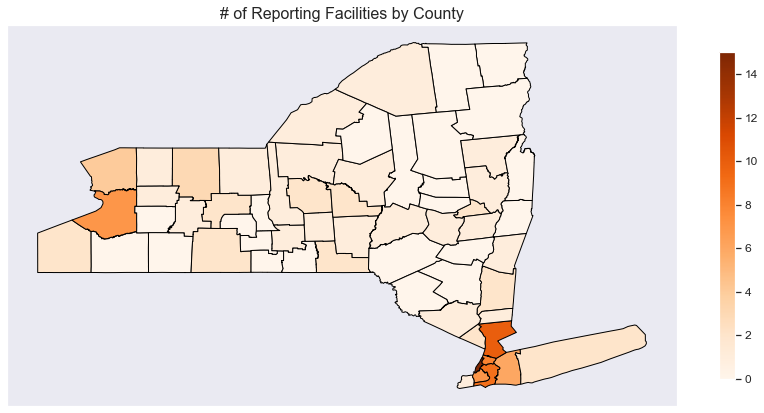

In [82]:
# Read the shapefile that contains NY counties
data_in_shapefile = shapefile.Reader('./shapefiles/tl_2010_36_county10/tl_2010_36_county10')

# Get the attributes and geometry for each record in the shapefile
attributes = []
geometry = []
field_names = [field[0] for field in data_in_shapefile.fields[1:]]  

for row in data_in_shapefile.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record))) 

# Populate a geopandas dataframe
gdf = gpd.GeoDataFrame(data = attributes, geometry = geometry)
gdf.head()

# Count facilities by county (include all counties, even if they have no facilities)
all_ny_counties = list(gdf['NAME10'])
new_dict = {
    'County': [],
    'Facilities': []
}
for county in all_ny_counties:
    new_dict['County'].append(county)
    new_dict['Facilities'].append(infections_df[infections_df['County Name'] == county]['Facility ID'].nunique())
    
county_df = pd.DataFrame.from_dict(new_dict)
county_df.head()

# Merge in facilities totals by county name
gdf = pd.merge(gdf, county_df, how='left',
        left_on='NAME10', right_on='County')

# Drop redundant columns
gdf.drop('County', axis = 1, inplace = True)

# Get min and max facility counts (will be used to define the map color range so it spans range of facility count values)
vmin = gdf['Facilities'].min()
vmax = gdf['Facilities'].max()
palette = 'Oranges'

# PLOT THE MAP
# This is a Choropleth map (map where the color of each shape is based on the value of an associated variable)
ax = gdf.plot(column = 'Facilities', cmap = palette, edgecolor = 'black', figsize = (15,15), linewidth = 1)
fig = ax.get_figure()

# Create a ScalarMappable object and use the set_array() function to add the facility counts to it
sm = matplotlib.cm.ScalarMappable(cmap = palette, norm = Normalize(vmin = vmin, vmax = vmax))
sm.set_array(gdf['Facilities'])

# Then pass the ScalarMappable object to the colorbar() function
# Set the shrink argument to 0.4 so the colorbar is slightly smaller than the map
fig.colorbar(sm, shrink = 0.4)

# Add a title and hide axis ticks and labels
plt.title('# of Reporting Facilities by County')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.show()

The facilities that reported hospital-acquired infection totals are primarily in or neighboring the New York City metropolitan area (southeast corner of the state). Erie county (on the western edge) also has several facilities reporting HAI data.  

Most other counties have fewer than 5 facilities that reported HAI information for 2008-2018.

### Infection Totals in NY since 2008

**How many total infections have been reported in the state of NY since 2008?  
What is the average number of infections reported per year?**

In [84]:
facility = 'New York State - All Hospitals'
year_count = infections_df['Year'].nunique()
total_infections = infections_df['Infections Observed'].sum()
avg_infections_per_year = total_infections / year_count
avg_indicator_value = infections_df['Indicator Value'].mean()

totals_df = pd.DataFrame({
    'Facility': facility,
    'Years in Dataset': year_count,
    'Total Infections Observed': int(total_infections),
    'Avg Infections per Year': avg_infections_per_year,
    'Avg Indicator Value': avg_indicator_value
}, index = range(1))

format_dict = {
    'Total Infections Observed':'{0:,}', 
    'Avg Infections per Year': '{:,.3f}', 
    'Avg Indicator Value': '{:.3f}'}

totals_df.style.format(format_dict).hide_index()

Facility,Years in Dataset,Total Infections Observed,Avg Infections per Year,Avg Indicator Value
New York State - All Hospitals,11,"211,806","19,255.091",1.964


**What is the trend in total infections observed from 2008 to 2018?  
Is there any correlation to the number of facilities that reported data each year?**

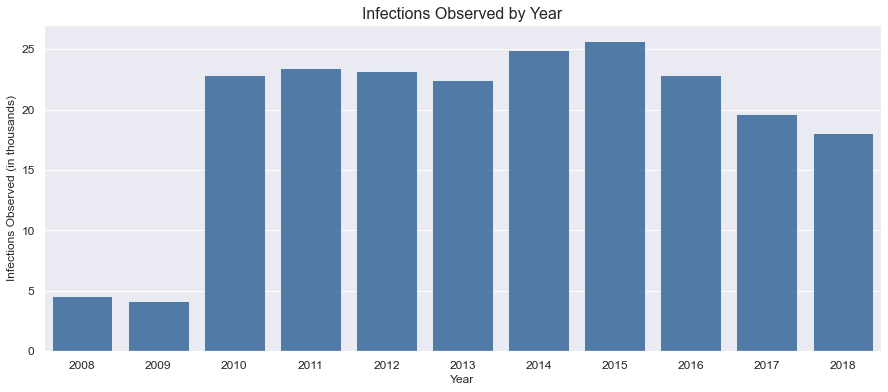

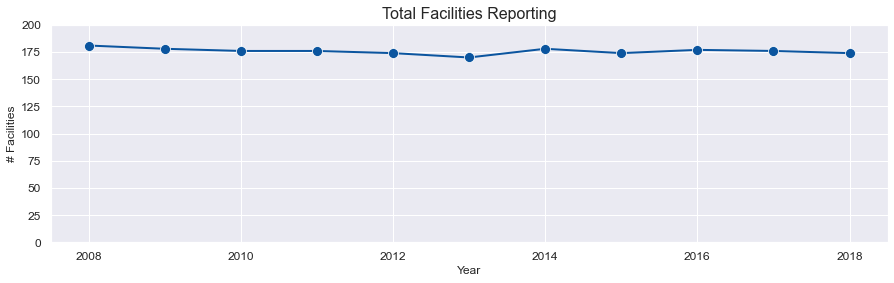

In [94]:
# Group data by year
year_group = infections_df.groupby('Year')

year_df = pd.merge(pd.DataFrame(year_group['Infections Observed'].sum()).reset_index(level = 0), 
          pd.DataFrame(year_group['Facility ID'].nunique().reset_index(level = 0)),
          how = 'left', left_on = 'Year', right_on = 'Year')

year_df['Infections Observed'] = year_df['Infections Observed'].astype(int)
year_df['Infections in Thousands'] = year_df['Infections Observed'] / 1000.0


# Plot data by year
color = list(sns.color_palette('Blues_r'))[0] #'#336FA2'


# Create barchart
plt.figure(figsize = (15,6))

ax1 = sns.barplot(x = 'Year', y = 'Infections in Thousands', color = color, alpha = 0.75, data = year_df)
plt.title('Infections Observed by Year', fontsize = 16)
plt.ylabel('Infections Observed (in thousands)', fontsize = 12)

plt.show()

# Create line chart
plt.figure(figsize = (15, 4))

ax2 = sns.lineplot(
    x = 'Year', y = 'Facility ID', data = year_df, sort = False, 
    color = color, marker = 'o', linewidth = 2, markersize = 10
)
plt.title('Total Facilities Reporting')
ax2.set_ylabel('# Facilities', fontsize = 12)
ax2.tick_params(axis = 'y', color = color)
ax2.set_ylim(0,200) # Set y-axis to start from zero to provide a firm context for any fluctuations

plt.show()

The charts above reveal there was a sharp uptick in the number of infections observed in 2010, despite having roughly the same number of reporting facilities.

**Why might that be? Did something change in 2010?**

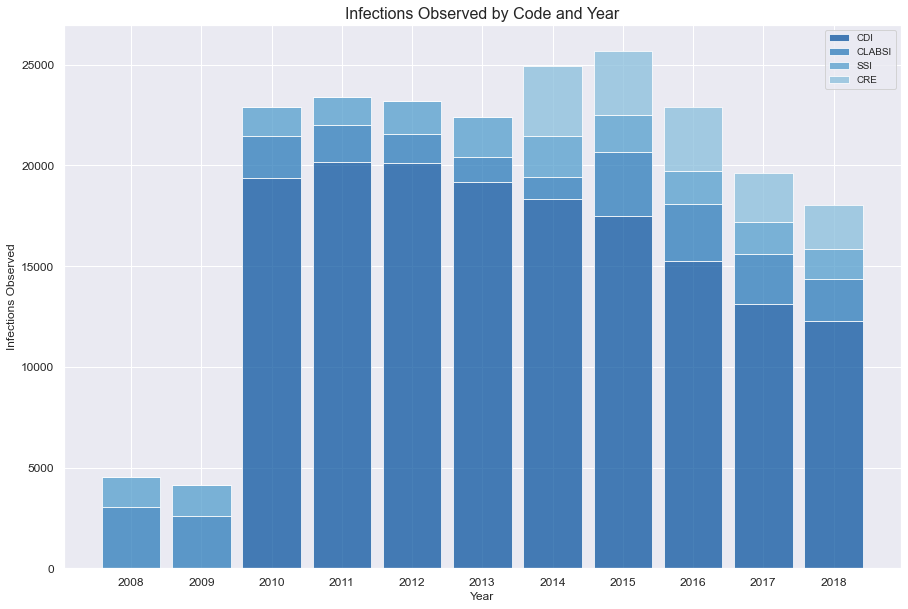

In [99]:
# Build dataframe with one row per year and one column per indicator code
years = infections_df['Year'].unique()
years.sort()
indicators = infections_df['Indicator Code'].unique()
data = np.zeros(len(years) * len(indicators)).reshape(len(years), len(indicators))

ind_year_df = pd.DataFrame(data, index = years, columns = indicators)

for yr in years:
    for ind in indicators:
        ind_year_df.loc[yr,ind] = infections_df[(infections_df['Year'] == yr) & (infections_df['Indicator Code'] == ind)]['Infections Observed'].sum()

# Identify the bars to be stacked
cdi = ind_year_df['CDI']
clabsi = ind_year_df['CLABSI']
ssi = ind_year_df['SSI']
cre = ind_year_df['CRE']
 
# Position the bars along the x-axis
r = np.array(range(len(years))) * 1.2
 
# Names of group and bar width
x_names = ind_year_df.index
barWidth = 1

plt.figure(figsize = (15,10))
palette = iter(sns.color_palette('Blues_r'))
alpha = 0.75

# Create stacked bars (bottom to top)
plt.bar(
    r, cdi, label = 'CDI',
    color = next(palette), alpha = alpha, edgecolor = 'white', width = barWidth
)
plt.bar(
    r, clabsi, bottom = cdi, label = 'CLABSI',
    color = next(palette), alpha = alpha, edgecolor = 'white', width = barWidth
)
plt.bar(
    r, ssi, bottom = cdi + clabsi, label = 'SSI',
    color = next(palette), alpha = alpha, edgecolor = 'white', width = barWidth
)
plt.bar(
    r, cre, bottom = cdi + clabsi + ssi, label = 'CRE',
    color = next(palette), alpha = alpha, edgecolor='white', width=barWidth)
 
# Plot X axis
plt.xticks(r, x_names)

# Add labels
plt.title('Infections Observed by Code and Year', fontsize = 16)
plt.xlabel("Year", fontsize = 12)
plt.ylabel('Infections Observed', fontsize = 12)
plt.legend()
 
# Show chart
plt.show()

By breaking down each year's total by indicator code, we can see the large jump in infections observed was caused by the introduction of CDI reporting in 2010. There was another smaller jump in 2014 when CRE reporting was added.

### Observed Infection Totals by Indicator Code

NOTE: For fairness in comparisons across the 4 indicator codes included in the dataset, this analysis will be restricted to only the years where all 4 indicators were reported (2014-2018).

In [100]:
# Group the infection data by indicator code
indicator_group = infections_df[infections_df['Year'] >= 2014].groupby('Indicator Code')

In [101]:
indicator_group['Infections Observed'].count()

Indicator Code
CDI       2584
CLABSI    4000
CRE       3524
SSI       2343
Name: Infections Observed, dtype: int64

In [102]:
# Collect metrics
facility_count = indicator_group['Facility ID'].nunique()
total_reports = indicator_group['Indicator Code'].count()
total_infections = indicator_group['Infections Observed'].sum()
percents = total_infections / infections_df[infections_df['Year'] >= 2014]['Infections Observed'].sum() * 100.0
avg_indicator_value = indicator_group['Indicator Value'].mean()

# Display in dataframe
format_dict = {
    'Facility Count':'{0:,}', 
    'Total Reports':'{0:,}', 
    'Total Infections Observed':'{0:,}', 
    'Percentage of Total': '{:.2f} %',
    'Avg Indicator Value': '{:.2f}'}

indicator_code_df = pd.DataFrame({
    'Facility Count': facility_count,
    'Total Reports': total_reports,
    'Total Infections Observed':total_infections.astype(int), 
    'Percentage of Total':percents,
    'Avg Indicator Value': avg_indicator_value
})

indicator_code_df.sort_values('Total Infections Observed', ascending = False).style.format(format_dict)

,Facility Count,Total Reports,Total Infections Observed,Percentage of Total,Avg Indicator Value
Indicator Code,,,,,
CDI,183,"2,649","76,499",68.80 %,2.91
CRE,183,"3,532","14,465",13.01 %,0.37
CLABSI,175,"4,265","11,622",10.45 %,1.00
SSI,169,"2,710","8,605",7.74 %,2.31


CDI has the largest number of infections observed, with almost 70% of the total in this category.

Although SSI makes up the smallest total observed infections, the Avg Indicator Value for this category is almost as high as CDI.

**For the latest year in the dataset (2018), what was the proportion of infections reported by each indicator code?**

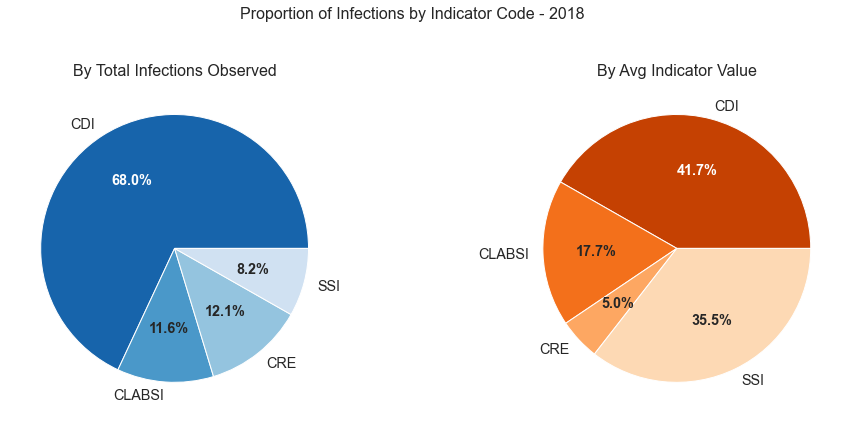

In [104]:
pie_df = infections_df[infections_df['Year'] == 2018].groupby('Indicator Code')['Infections Observed'].sum().reset_index()
pie2_df = infections_df[infections_df['Year'] == 2018].groupby('Indicator Code')['Indicator Value'].mean().reset_index()

# Create 2 side-by-side subplots
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,7))

# Plot first pie chart
labels = pie_df['Indicator Code']
values = pie_df['Infections Observed']
pie_palette = list(sns.color_palette('Blues_r', n_colors = len(labels)))

patches, texts, autotexts = ax1.pie(values, labels = labels, colors = pie_palette, autopct = '%1.1f%%') #plot first pie
ax1.title.set_text('By Total Infections Observed')

for t in texts:
    t.set_size('large')
for t in autotexts:
    t.set_size('large')
    t.set_weight('bold')
autotexts[0].set_color('white') # Make the % easier to read on the darkest slice

# Plot second pie chart
labels = pie2_df['Indicator Code']
values = pie2_df['Indicator Value']
pie_palette = list(sns.color_palette('Oranges_r', n_colors = len(labels)))

patches, texts, autotexts = ax2.pie(values, labels = labels, colors = pie_palette, autopct = '%1.1f%%') #plot second pie
ax2.title.set_text('By Avg Indicator Value')

for t in texts:
    t.set_size('large')
for t in autotexts:
    t.set_size('large')
    t.set_weight('bold')
autotexts[0].set_color('white') # Make the % easier to read on the darkest slice

# Adjust the spacing between subplots
fig.subplots_adjust( 
    wspace = 0.5, 
    hspace = 0.3,
    left = 0.125,
    right = 0.9,
    top = 0.9,
    bottom = 0.1
)

# Set a shared title for the entire view
fig.suptitle('Proportion of Infections by Indicator Code - 2018', fontsize = 16)
    
plt.show()

The proportions for 2018 appear to be consistent with the overall totals for 2014-2018, with CDI reporting the largest number of total infections, and SSI having a relatively low *total* number of observed infections but a much higher *incidence* of infections.

### Surgical Site Infections by Procedure Type

Due to the outsized incidence of infection shown in the analysis above, the SSI indicator code may have room for improvement.

Because SSI has been reported in every year of the dataset, all 11 years can be included in the analysis.

**Which procedures resulted in the most surgical site infections?**

In [105]:
# Separate out just the SSI infection data
ssi_df = infections_df[infections_df['Indicator Code'] == 'SSI']

# Group the SSI data by procedure
procedure_group = ssi_df.groupby('Indicator Area')

# Collect metrics
facility_count = procedure_group['Facility ID'].nunique()
total_infections = procedure_group['Infections Observed'].sum()
percents = total_infections / ssi_df['Infections Observed'].sum() * 100.0
rate_per_100 = procedure_group['Indicator Value'].mean()

# Display as dataframe
format_dict = {
    'Total Infections Observed':'{0:,}', 
    'Percentage of Total': '{:.2f} %', 
    'Infections per 100 Procedures': '{:.3f}'}

ssi_totals_df = pd.DataFrame({
    'Facility Count': facility_count, 
    'Total Infections Observed': total_infections.astype(int), 
    'Percentage of Total': percents,
    'Infections per 100 Procedures': rate_per_100})

ssi_totals_df.sort_values('Infections per 100 Procedures', ascending = False).style.format(format_dict)

,Facility Count,Total Infections Observed,Percentage of Total,Infections per 100 Procedures
Indicator Area,,,,
Colon,182,"10,125",55.87 %,5.082
CABG chest site,43,"2,348",12.96 %,1.839
Hysterectomy,168,"1,696",9.36 %,1.422
Hip,176,"3,257",17.97 %,1.134
CABG donor site,42,695,3.84 %,0.646


By both total count and incidence per 100 procedures, surgical site infections were most common after Colon procedures.

### Surgical Site Infections by Facility

Raw counts of infections reported may distort the impression of a particular facility's safety when that facility performs a very large or small number of procedures. The SSI indicator value levels the playing field by calculating the number of infections observed for every 100 procedures performed.

Since the goal is to improve current processes, this analysis will focus on the most recent data available in the dataset, which is from 2018.

**Which 5 facilities have the highest SSI indicator values for 2018?**

In [80]:
infections_df.loc[(infections_df['Year'] == 2018) & (infections_df['Indicator Code'] == 'SSI'), ['Facility ID', 'Hospital Name', 'Indicator Name', 'Year', 'Infections Observed', 'Infections Predicted', 'Indicator Value']].sort_values('Indicator Value', ascending = False).head().style.hide_index()

Facility ID,Hospital Name,Indicator Name,Year,Infections Observed,Infections Predicted,Indicator Value
1061,Montefiore Mount Vernon Hospital,SSI Colon,2018,3.000000,0.960000,12.860000
1633,Queens Hospital Center,SSI Colon,2018,5.000000,1.660000,12.350000
599,Faxton-St Lukes Healthcare St Lukes Division,SSI Hysterectomy,2018,7.000000,0.720000,10.760000
1315,Kingsbrook Jewish Medical Center,SSI Colon,2018,4.000000,1.750000,9.340000
678,F F Thompson Hospital,SSI Colon,2018,5.000000,2.230000,9.190000


As might be expected from the summary-level data, 4 of the top 5 highest incidence rates in 2018 are for Colon procedures.

**What is the distribution of SSI Colon indicator values across all facilities in 2018?**

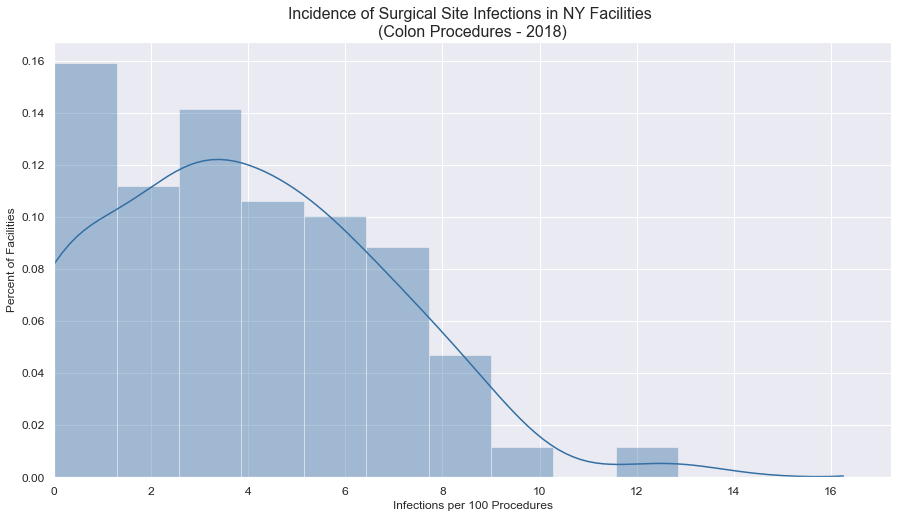

In [41]:
plt.figure(figsize = (15,8))

colon_df = infections_df[(infections_df['Year'] == 2018) & (infections_df['Indicator Name'] == 'SSI Colon')]

g = sns.distplot(colon_df['Indicator Value'], bins = 10, color = '#336FA2')
plt.title('Incidence of Surgical Site Infections in NY Facilities \n(Colon Procedures - 2018)', fontsize = 16)
plt.xlabel('Infections per 100 Procedures', fontsize = 12)
plt.ylabel('Percent of Facilities', fontsize = 12)
g.set(xlim = 0)

plt.show()

Roughly 16% of facilities were assigned to the lowest bin, representing an incidence of about 0 to 1.5 surgical site infections per 100 procedures. This is the largest bin.  

However, almost as many facilities (~14%) reported an incidence level between 2.5 and about 4 infections per 100 procedures, and the percent of facilities reporting higher incidences doesn't drop below 5% until the rate is almost 8 per 100 procedures.

**How does this compare to other procedure types?**

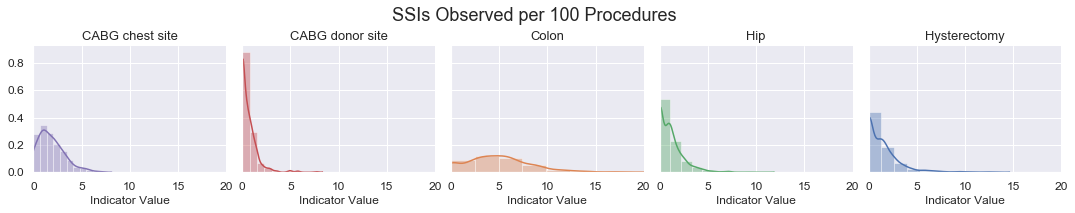

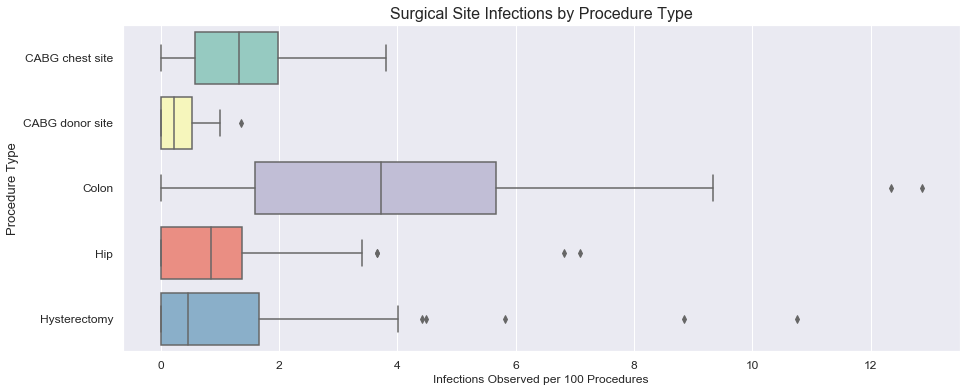

In [46]:
order = ssi_df['Indicator Area'].value_counts().index.sort_values()

ssi_grid = sns.FacetGrid(
    ssi_df, col ="Indicator Area", 
    col_wrap = 5, aspect = 1, 
    col_order = order,
    hue = 'Indicator Area'
)
ssi_grid.map(sns.distplot, "Indicator Value", bins = 10)

ssi_grid.set(xlim = [0,20])

plt.suptitle('SSIs Observed per 100 Procedures', fontsize = 18)
ssi_grid.set_titles("{col_name}", size = 13)
ssi_grid.fig.subplots_adjust(top=.8)

plt.show()
print('\n')

plt.figure(figsize = (15,6))

g = sns.boxplot(x = 'Indicator Value', y = 'Indicator Area',
                palette = 'Set3',
                data = ssi_df[ssi_df['Year'] == 2018],
                order = order
               )

plt.title('Surgical Site Infections by Procedure Type', fontsize = 16)
plt.xlabel('Infections Observed per 100 Procedures', fontsize = 12)
plt.ylabel('Procedure Type', fontsize = 13)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)

plt.show()

In the top series of charts, most of the procedures show the tallest bar on the far left, which then drops off quickly as you move to the right. But the Colon chart (center) has a much flatter shape than the other procedures. This means there is a much wider variation in the incidence of SSI after Colon procedures.

The bottom chart provides a more detailed view of this same information. The shaded boxes represent the data points that lie within the 25th and 75th percentiles. The line within the box is the median for that procedure type. The outer lines (whiskers) show how widely distributed the incidence rates are for that procedure type; outliers are shown as diamonds. 

The whiskers and shaded box are both considerably wider for Colon than for any other procedure type, and the median value is much higher (~3.9). All other procedures have a median value less than 2.

<a id='Conclusion'></a>
## Conclusion  

**Because there is a large degree of variability in incidence rates across NY facilities, Colon procedures may be an ideal area to focus on for reducing surgical site infections. Facilities with lower incidence rates should be studied and their processes documented to see if they can be put into place at facilities experiencing higher incidence rates.**

These facilities have the lowest SSI Colon indicator values. They may be good models to study for developing standardized processes.

In [102]:
infections_df.loc[(infections_df['Year'] == 2018) & (infections_df['Indicator Name'] == 'SSI Colon'), ['Facility ID', 'Hospital Name', 'Indicator Name', 'Year', 'Infections Observed', 'Infections Predicted', 'Indicator Value', 'Denominator']].sort_values(['Indicator Value', 'Denominator'], ascending = [True, False]).head(10).style.hide_index()

Facility ID,Hospital Name,Indicator Name,Year,Infections Observed,Infections Predicted,Indicator Value,Denominator
207,Buffalo General Medical Center,SSI Colon,2018,0.000000,5.660000,0.000000,116.000000
1301,Kings County Hospital Center,SSI Colon,2018,0.000000,4.160000,0.000000,92.000000
694,St Luke's Cornwall Hospital/Newburgh,SSI Colon,2018,0.000000,2.650000,0.000000,72.000000
938,Peconic Bay Medical Center,SSI Colon,2018,0.000000,3.030000,0.000000,67.000000
1288,Brooklyn Hospital Center - Downtown Campus,SSI Colon,2018,0.000000,2.540000,0.000000,65.000000
1178,BronxCare Hospital Center,SSI Colon,2018,0.000000,2.450000,0.000000,64.000000
1176,SBH Health System,SSI Colon,2018,0.000000,3.260000,0.000000,59.000000
671,Geneva General Hospital,SSI Colon,2018,0.000000,1.910000,0.000000,58.000000
628,UPSTATE University Hospital at Community General,SSI Colon,2018,0.000000,2.460000,0.000000,56.000000
896,St Charles Hospital,SSI Colon,2018,0.000000,1.580000,0.000000,50.000000


These facilities have the highest SSI Colon indicator values. Prioritizing the implementation of new processes at these facilities has the greatest chance of having a measurable impact on the total number of observed SSI after Colon procedures.

In [105]:
infections_df.loc[(infections_df['Year'] == 2018) & (infections_df['Indicator Name'] == 'SSI Colon'), ['Facility ID', 'Hospital Name', 'Indicator Name', 'Year', 'Infections Observed', 'Infections Predicted', 'Indicator Value']].sort_values('Indicator Value', ascending = False).head().style.hide_index()

Facility ID,Hospital Name,Indicator Name,Year,Infections Observed,Infections Predicted,Indicator Value
1061,Montefiore Mount Vernon Hospital,SSI Colon,2018,3.000000,0.960000,12.860000
1633,Queens Hospital Center,SSI Colon,2018,5.000000,1.660000,12.350000
1315,Kingsbrook Jewish Medical Center,SSI Colon,2018,4.000000,1.750000,9.340000
678,F F Thompson Hospital,SSI Colon,2018,5.000000,2.230000,9.190000
292,Sisters of Charity Hospital - St Joseph Campus,SSI Colon,2018,3.000000,1.370000,9.000000


[Back to Top](#Top)